# Practice2 - From Fully-Connected to Fully-Convolutional Networks

- Reference code
  - https://github.com/bodokaiser/piwise
  - https://github.com/wkentaro/pytorch-fcn (pre-trained model included)

In [1]:
# libraries for plot
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

### Examine VGG-16 architecture

In [3]:
# load VGG16 provided by torchvision
vgg16 = models.vgg16(pretrained=True)
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

In [4]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

#### check that VGG16's output from feature layer

In [5]:
feat = vgg16.features.forward(torch.zeros(1,3,224,224))
print(feat.size(), 512*7*7)

torch.Size([1, 512, 7, 7]) 25088


### Exercise 2. implement FCN with VGG-16 network

- view function, change tensor into different shape keeping the same number of elements
  - https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view

In [6]:
class FCN32(nn.Module):
    def __init__(self, num_classes=21):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        
        self.feats = vgg16.features
        
        self.fconn = nn.Sequential(
            nn.Conv2d(512, 4096, 7, 1, 3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Conv2d(4096, 4096, 1),
            nn.ReLU(inplace=True),
            nn.Dropout(),
        )
        
        # weight copy
        self.fconn[0].weight.data = vgg16.classifier[0].weight.view(self.fconn[0].weight.data.size())
        self.fconn[3].weight.data = vgg16.classifier[3].weight.view(self.fconn[3].weight.data.size())
        
        # bias copy
        self.fconn[0].bias.data = vgg16.classifier[0].bias.view(self.fconn[0].bias.data.size())
        self.fconn[3].bias.data = vgg16.classifier[3].bias.view(self.fconn[3].bias.data.size())
        
        # new score layer
        self.score = nn.Conv2d(4096, num_classes, 1)
        
    def forward(self, x):
        feats = self.feats(x)
        #print(feats.size())
        fconn = self.fconn(feats)
        score = self.score(fconn)
        upsample_t = F.upsample(score, scale_factor=32, mode='bilinear', align_corners=True)
        return upsample_t

In [7]:
fcn = FCN32()
fcn.forward(torch.zeros(1,3,512,512)).size()

/home/tackgeun/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


torch.Size([1, 21, 512, 512])

In [8]:
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset

EXTENSIONS = ['.jpg', '.png']

def load_image(file):
    return Image.open(file)

def is_image(filename):
    return any(filename.endswith(ext) for ext in EXTENSIONS)

def image_path(root, basename, extension):
    return os.path.join(root, basename + extension)

def image_basename(filename):
    return os.path.basename(os.path.splitext(filename)[0])

def label_ignore(label, image_size, crop_size):
    
    label
    return label

class VOC12(Dataset):
    def __init__(self, root, split='train', input_transform=None, target_transform=None, crop_size=512):
        self.images_root = os.path.join(root, 'JPEGImages')
        self.labels_root = os.path.join(root, 'SegmentationClass')

#         self.filenames = [image_basename(f)
#             for f in os.listdir(self.labels_root) if is_image(f)]
#         self.filenames.sort()
        self.filenames = []
        with open(os.path.join(root, 'ImageSets', 'Segmentation', '%s.txt' % split)) as f:
            for r in f.readlines():
                self.filenames.append(r[0:-1])
        
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.crop_size = crop_size
    def __getitem__(self, index):
        filename = self.filenames[index]

        with open(image_path(self.images_root, filename, '.jpg'), 'rb') as f:
            image = load_image(f).convert('RGB')
        with open(image_path(self.labels_root, filename, '.png'), 'rb') as f:
            label = load_image(f).convert('P')

        if self.input_transform is not None:
            image = self.input_transform(image)
        if self.target_transform is not None:
            label = self.target_transform(label)
            
        return image, label

    def __len__(self):
        return len(self.filenames)

In [9]:
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, CenterCrop, Normalize
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.transforms.functional as Ftrans
import numbers

class CenterCropWithIgnore:
    def __init__(self, size, ignore):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        
        self.ignore = int(ignore)

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped.

        Returns:
            PIL Image: Cropped image,
                       outside of image is filled with ignore label
        """
        return 

    def __call__(self, image):
        # Center Crop
        Fimage = Ftrans.center_crop(image, self.size)
        
        # PIL image to Torch Tensor
        label = torch.from_numpy(np.array(Fimage)).long().unsqueeze(0)

        # Write ignore label out-of-image region
        W, H = Fimage.size
        Wimg,Himg = image.size
        ys = (H - Himg) // 2
        xs = (W - Wimg) // 2
        
        label[0, 0:ys, 0:] = self.ignore # top
        label[0, (H-ys):H, 0:] = self.ignore # bottom
        label[0, ys:(H-ys), 0:xs] = self.ignore # left
        label[0, ys:(H-ys), (W-xs):W] = self.ignore # left
        
        return label
    
input_transform = Compose([ 
    CenterCrop(512), 
    ToTensor(), 
    Normalize([.485, .456, .406], [.229, .224, .225]), 
])
target_transform = CenterCropWithIgnore(512, 255)

### Network, optimizer, loss declare

In [52]:
net = FCN32()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=255)

### Compute mean IU via confusion matrix
- PASCAL VOC evaluation code https://github.com/npinto/VOCdevkit/blob/master/VOCcode/VOCevalseg.m

In [53]:
def compute_confusion(pred, gt, nc=21):
    p = pred.view(-1) # columnize the matrix
    g = gt.view(-1)

    res = p * nc + g

    res[g>20] = -1

    val, cnt = np.unique(res.numpy(), return_counts=True)

    conf = torch.zeros(nc*nc)
    for i in range(1, val.size):
        conf[int(val[i])] = int(cnt[i])

    conf = conf.view(nc,nc)
    
    return conf
    
def compute_meanIU(conf):
    r = torch.sum(conf, dim=0)
    c = torch.sum(conf, dim=1)
    d = torch.zeros(conf.size(0))
    
    for i in range(0, conf.size(0)):
        d[i] = conf[i,i]
        
    mean = torch.mean(d / (r+c-d))
    mean[torch.isnan(mean)] = 0
    
    return mean

### train a single epoch

In [ ]:
gpuid = 0
DATAROOT = './VOC2012/'
num_classes = 21
loader = DataLoader(VOC12(DATAROOT, 'train', input_transform, target_transform),
        num_workers=1, batch_size=10, shuffle=True)

net.cuda(gpuid)
net.train()
all_loss = 0
all_conf = torch.zeros(num_classes, num_classes)
for i, data in enumerate(loader):
    image = data[0].cuda(gpuid)
    label = data[1].squeeze().cuda(gpuid)
    
    # write code in below
    optimizer.zero_grad()
    pred = net.forward(image)
    loss = loss_fn(pred, label)
    loss.backward()
    optimizer.step()
    
    # training stats
    all_loss = all_loss + loss.item()
    
    val, pred_seg = pred.cpu().max(1)
    all_conf = all_conf + compute_confusion(pred_seg, label.cpu())
    meaniu = compute_meanIU(all_conf)
    
    if((i % 50 == 0) or (i == len(loader)-1)):
        print("[{:4d}/{:4d}] loss:{:.3f} meanIU:{:.3f}".format(i, len(loader),all_loss/(i+1), meaniu))

/home/tackgeun/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[   0/ 147] loss:2.925 meanIU:0.016
[  50/ 147] loss:1.034 meanIU:0.125


### test a single epoch

In [34]:
DATAROOT = './VOC2012/'
loader = DataLoader(VOC12(DATAROOT, 'val', input_transform, target_transform),
        num_workers=1, batch_size=10, shuffle=False)

net.eval()
all_loss_val = 0
for i, data in enumerate(loader):
    image = data[0].cuda(gpuid)
    label = data[1].squeeze().cuda(gpuid)
    
    pred = net.forward(image)
    loss = loss_fn(pred, label)
    
    all_loss_val = all_loss_val + loss.item()

    val, pred_seg = pred.cpu().max(1)
    all_conf = all_conf + compute_confusion(pred_seg, label.cpu())
    meaniu = compute_meanIU(all_conf)
    
    if((i % 50 == 0) or (i == len(loader)-1)):
        print("[{:4d}/{:4d}] loss:{:.3f} meanIU:{:.3f}".format(i, len(loader),all_loss/(i+1), meaniu))

/home/tackgeun/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


[   0/ 145] loss:113.170 meanIU:0.237
[  50/ 145] loss:2.219 meanIU:0.276
[ 100/ 145] loss:1.120 meanIU:0.301
[ 144/ 145] loss:0.780 meanIU:0.311


### Visualize results

#### code for visualization of segmentation

In [37]:
def get_voc_colormap():
    N = 256 # number of colormap
    VOCcolormap = np.zeros([N, 3], dtype=np.uint8)
    for i in range(0, N):
        (r,b,g,idx)=(0,0,0,i)
        for j in range(0, 8):
            r = r | ((idx & 1) << (7 - j))
            g = g | ((idx & 2) << (7 - j))
            b = b | ((idx & 4) << (7 - j))
            idx = idx >> 3
        VOCcolormap[i, :] = [r, g >> 1, b >> 2]
    return VOCcolormap

def return_pascal_segmentation(input_im):
    VOCcolormap = get_voc_colormap()
    im = Image.fromarray(input_im, mode='P')
    im.putpalette(np.reshape(VOCcolormap, 768, 'C'))
    return im

#### plot code

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5,1,'predicted segmentation')

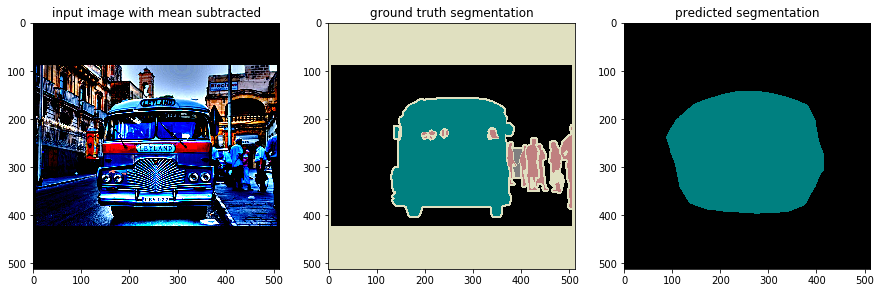

In [38]:
im_idx = 0
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data[0][im_idx,:,:,:].permute(1,2,0)) # C x H x W --> H x W x C
plt.title('input image with mean subtracted')

plt.subplot(1,3,2)
plt.imshow(return_pascal_segmentation(data[1][im_idx,0,:,:].numpy().astype(np.uint8)))
plt.title('ground truth segmentation')

plt.subplot(1,3,3)
val, pred_seg = pred.cpu().max(1)
plt.imshow(return_pascal_segmentation(pred_seg[im_idx].numpy().astype(np.uint8)))
plt.title('predicted segmentation')